## EDA (Condensed)

In [1]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install scikeras
!whichgpu


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


You are allocated NVIDIA GeForce RTX 3090 on aloha
You are using GPU 0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split 

df = pd.read_csv("completed_flat_price_2017_2023.csv")
df['date'] = pd.to_datetime(df['month'], format='%Y-%m')

# pre processing:
# removing outliers (3std away) for resale_price
def three_sd_range(series):
    mean = series.mean()
    sd = series.std()
    low = mean - 3*sd
    high = mean + 3*sd
    return (low, high)

lower, upper = three_sd_range(df["resale_price"])
df_cleaned  = df[ (df.resale_price >= lower) & (df.resale_price <= upper) ]

# converting remaining_lease to int format:
def convert_lease_to_int(lease_str):
    parts = lease_str.split()
    years = int(parts[0])
    return years

df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)

# encoding flat_type and storey_range to ordinal data:
labelencoder = LabelEncoder()
df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
df_cleaned['storey_range_encoded'] = labelencoder.fit_transform(df_cleaned['storey_range'])


/common/home/users/r/ryanlim.2021/tmp/ipykernel_2708742/4248652671.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)
/common/home/users/r/ryanlim.2021/tmp/ipykernel_2708742/4248652671.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
/common/home/users/r/ryanlim.2021/tmp/ipykernel_2708742/4248652671.py:37: SettingWithCopyWarning: 

#### Inflation using CPI

In [3]:
# Read the CSV file. The header is in the first row by default.
inflation_rate = pd.read_csv('annual_CPI.csv')

# Transpose the DataFrame so that years become the index
inflation_rate = inflation_rate.transpose().reset_index()
inflation_rate.columns = ['Year', 'CPI']  # Renaming the columns
inflation_rate.sort_index(ascending=False, inplace=True)

# Convert 'Year' to integer and 'CPI' to float
inflation_rate['Year'] = inflation_rate['Year'].astype(int)
inflation_rate['CPI'] = inflation_rate['CPI'].astype(float)

# Calculate the inflation rate
inflation_rate['Inflation Rate'] = inflation_rate['CPI'].diff() / inflation_rate['CPI'].shift(1) * 100

# Setting the inflation rate for the base year (the first year) to 0%
inflation_rate.iloc[0, inflation_rate.columns.get_loc('Inflation Rate')] = 0

# Display the DataFrame
print(inflation_rate)

   Year      CPI  Inflation Rate
6  2017   99.004        0.000000
5  2018   99.438        0.438366
4  2019  100.000        0.565176
3  2020   99.818       -0.182000
2  2021  102.119        2.305195
1  2022  108.370        6.121290
0  2023  113.595        4.821445


#### Calculating adjusted price with inflation

In [4]:
# Add a 'year' column to df2 by converting 'month' to datetime and extracting the year
df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year

# Merge df2 with the inflation_rate DataFrame on the 'year' column
# Make sure the inflation_rate DataFrame has 'Year' and 'Inflation Rate' columns
df_cleaned = df_cleaned.merge(inflation_rate, left_on='year', right_on='Year', how='left')

# Calculate the adjusted_price
df_cleaned['adjusted_price'] = round(df_cleaned['resale_price'] * (1 + df_cleaned['Inflation Rate'] / 100),2)

# Since we only need the adjusted_price, drop the extra columns
df_cleaned.drop(columns=['Year', 'Inflation Rate', 'year'], inplace=True)

# extracting features:
df2= df_cleaned[['month','town', 
                 'flat_type', 'flat_type_encoded',
                 'storey_range', 'storey_range_encoded',
                 'floor_area_sqm', 'remaining_lease_years', 'full_address', 'resale_price']]
# Not using adjusted_price as inflation may not consistently affect all prices - raw prices are hypothesised to result in better model training

/common/home/users/r/ryanlim.2021/tmp/ipykernel_2708742/3932039432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year


#### Normalisation of continuous variables 
Floor area, remaining lease years, resale price

In [5]:
# Applying one hot encoding to town:
from sklearn.preprocessing import LabelBinarizer
labelbinarizer = LabelBinarizer()
x = labelbinarizer.fit_transform(df2["town"])
encoded_df = pd.DataFrame(x, columns=labelbinarizer.classes_)
encoded_df.head()

# Normalizing numerical variables:
from sklearn.preprocessing import StandardScaler
columns = [ 'floor_area_sqm', 'remaining_lease_years', 'resale_price']
df2_normalized = StandardScaler().fit_transform(df2[columns])
df2_normalized= pd.DataFrame(df2_normalized, columns = columns)

df2 = df2.reset_index(drop=True)
df2_normalized = df2_normalized.reset_index(drop=True)

df2_normalized[['flat_type_encoded', 'storey_range_encoded']] = df2[['flat_type_encoded', 'storey_range_encoded']]
df2_normalized['year'] = df2['month'].str.slice(0,4)
df2_normalized = pd.concat([df2_normalized, encoded_df], axis=1)

# Change data type of year to int
df2_normalized['year'] = df2_normalized['year'].astype(int)

df2_normalized

,floor_area_sqm,remaining_lease_years,resale_price,flat_type_encoded,storey_range_encoded,year,ANG MO KIO,BEDOK,BISHAN,BUKIT BATOK,...,PASIR RIS,PUNGGOL,QUEENSTOWN,SEMBAWANG,SENGKANG,SERANGOON,TAMPINES,TOA PAYOH,WOODLANDS,YISHUN
0,-2.225324,-0.969351,-1.539479,1,3,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.266810,-1.042624,-1.424603,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.266810,-0.896079,-1.348019,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.225135,-0.896079,-1.328874,2,1,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.266810,-0.896079,-1.328874,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145605,0.983615,-0.822806,1.064368,4,2,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145606,1.233662,-0.749534,1.447287,4,0,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145607,1.025289,-0.749534,1.447287,4,3,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145608,2.025478,-0.749534,2.328000,5,3,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


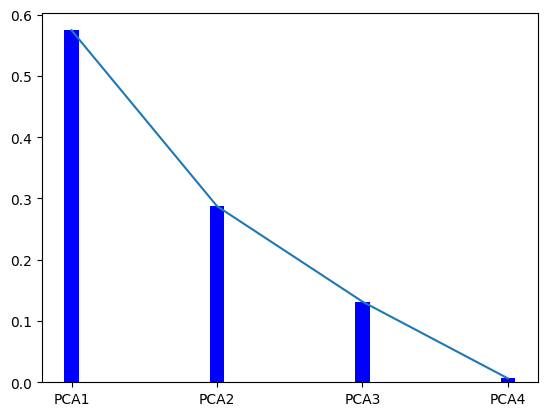

In [6]:
# PCA
from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
pca = PCA(n_components=4)

# x_pca = pca.fit_transform(df2_normalized[['floor_area_sqm', 'remaining_lease_years', 'resale_price']])
x_pca = pca.fit_transform(df2_normalized[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded']])

x_pca = pd.DataFrame(x_pca)
df4_names = []
y= pca.explained_variance_ratio_

for i in range(len(y)):
    df4_names.append('PCA'+str(i+1))

default_x_ticks = range(len(df4_names))

plt.plot(default_x_ticks, y)
plt.bar(default_x_ticks, y,width=0.1,color= 'blue')
plt.xticks(default_x_ticks, df4_names)
plt.show()

In [7]:
# Splitting into 3 df: pre-covid, post-covid, and full dataset
full_dataset = df2_normalized
precovid_dataset = df2_normalized[(df2_normalized['year'] >= 2017) & (df2_normalized['year'] <= 2019)] # Data from 2017 ~ 2019
postcovid_dataset = df2_normalized[(df2_normalized['year'] >= 2020) ] # Data from 2020 ~ 2023

# Extracting essential columns for model training
full_dataset = full_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'resale_price']]
precovid_dataset = precovid_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'resale_price']]
postcovid_dataset = postcovid_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'resale_price']]

In [8]:
# splitting into train-test split for all 3 data sets
# use randome state=42

# For full_dataset:
X1=full_dataset.drop(columns='resale_price')
y1= full_dataset['resale_price']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# For precovid_dataset:
X2=precovid_dataset.drop(columns='resale_price')
y2= precovid_dataset['resale_price']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# For postcovid_dataset:
X3=postcovid_dataset.drop(columns='resale_price')
y3= postcovid_dataset['resale_price']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

## ANN (Artificial Neural Network)

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from joblib import dump, load
import os

# Define the model
def buildModel(input_dim, units1=128, units2=64, units3=32):
    model = Sequential()
    model.add(Dense(units1, input_dim=input_dim, activation='relu'))
    model.add(Dense(units2, activation='relu'))
    model.add(Dense(units3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

# Define grid search parameters for hyperparameter tuning (modify as needed)
param_grid = {
    'epochs': [10, 20, 50],
    'batch_size': [32, 64, 128],
    'units1': [32, 64, 128],
    'units2': [16, 32, 64],
    'units3': [8, 16, 32],
}

model_example = buildModel(X_train1.shape[1])
model_example.summary()

2024-03-28 12:26:27.881758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 12:26:27.881824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 12:26:27.910832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 12:26:28.081078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-03-28 12:26:38.449982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 128)               640       


 dense_1 (Dense)             (None, 64)                8256      


 dense_2 (Dense)             (None, 32)                2080      


 dense_3 (Dense)             (None, 1)                 33        


Total params: 11009 (43.00 KB)


Trainable params: 11009 (43.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


2024-03-28 12:26:49.360381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


#### Full Dataset

In [10]:
if (not os.path.exists('gridsearch/ANN_fulldata.joblib')):

    # Create a KerasRegressor
    regressor_fulldata = KerasRegressor(model=buildModel, input_dim=X_train1.shape[1], verbose=0, epochs=100, batch_size=128, units1=256, units2=128, units3=64)

    # Create a GridSearchCV and fit the model
    grid_fulldata = GridSearchCV(estimator=regressor_fulldata, param_grid=param_grid, cv=2, verbose=3)
    grid_result_fulldata = grid_fulldata.fit(X_train1, y_train1)

    # Summarize results
    print(f"Best: {grid_result_fulldata.best_score_} using {grid_result_fulldata.best_params_}")

    # Save grid_result to a file
    dump(grid_result_fulldata, 'gridsearch/ANN_fulldata.joblib')

else:
    # Load grid_result from a file
    grid_result_fulldata = load('gridsearch/ANN_fulldata.joblib')

    # Summarize results
    print(f"Best: {grid_result_fulldata.best_score_} using {grid_result_fulldata.best_params_}")

Best: 0.6458730598057187 using {'batch_size': 32, 'epochs': 50, 'units1': 128, 'units2': 64, 'units3': 32}


2024-03-28 12:26:50.475572: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://1fb5b1c6b949465abad4eeaa1b3cc262: INVALID_ARGUMENT: ram://1fb5b1c6b949465abad4eeaa1b3cc262 is a directory.


In [11]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_fulldata = load('gridsearch/ANN_fulldata.joblib')
test_score = grid_result_fulldata.score(X_test1, y_test1)
print(f"Test MAE: {test_score}")

2024-03-28 12:26:51.109821: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://7e8dbf92403a421b8e3e1e3a0ec63ac4: INVALID_ARGUMENT: ram://7e8dbf92403a421b8e3e1e3a0ec63ac4 is a directory.


Test MAE: 0.6430637799714232


#### Pre-COVID Dataset

In [12]:
if (not os.path.exists('gridsearch/ANN_precovid.joblib')):

    # Create a KerasRegressor
    regressor_precovid = KerasRegressor(model=buildModel, input_dim=X_train2.shape[1], verbose=0, epochs=100, batch_size=128, units1=256, units2=128, units3=64)

    # Create a GridSearchCV and fit the model
    grid_precovid = GridSearchCV(estimator=regressor_precovid, param_grid=param_grid, cv=2, verbose=3)
    grid_result_precovid = grid_precovid.fit(X_train2, y_train2)

    # Summarize results
    print(f"Best: {grid_result_precovid.best_score_} using {grid_result_precovid.best_params_}")

    # Save best model
    dump(grid_result_precovid, 'gridsearch/ANN_precovid.joblib')

else:
    # Load grid_result from a file
    grid_result_precovid = load('gridsearch/ANN_precovid.joblib')

    # Summarize results
    print(f"Best: {grid_result_precovid.best_score_} using {grid_result_precovid.best_params_}")

Best: 0.6457073425330682 using {'batch_size': 32, 'epochs': 50, 'units1': 128, 'units2': 64, 'units3': 16}


2024-03-28 12:26:53.810251: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://1e463896fc3d498ba83a88981573e86e: INVALID_ARGUMENT: ram://1e463896fc3d498ba83a88981573e86e is a directory.


In [13]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_precovid = load('gridsearch/ANN_precovid.joblib')
test_score = grid_result_precovid.score(X_test2, y_test2)
print(f"Test MAE: {test_score}")

2024-03-28 12:26:54.400208: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://5afe8c1e8c7d4011ac29dcdbb72d500a: INVALID_ARGUMENT: ram://5afe8c1e8c7d4011ac29dcdbb72d500a is a directory.


Test MAE: 0.64724037502495


#### Post-COVID Dataset

In [14]:
if (not os.path.exists('gridsearch/ANN_postcovid.joblib')):

    # Create a KerasRegressor
    regressor_postcovid = KerasRegressor(model=buildModel, input_dim=X_train3.shape[1], verbose=0, epochs=100, batch_size=128, units1=256, units2=128, units3=64)

    # Create a GridSearchCV and fit the model
    grid_postcovid = GridSearchCV(estimator=regressor_postcovid, param_grid=param_grid, cv=2, verbose=3)
    grid_result_postcovid = grid_postcovid.fit(X_train3, y_train3)

    # Summarize results
    print(f"Best: {grid_result_postcovid.best_score_} using {grid_result_postcovid.best_params_}")

    # Save best model
    dump(grid_result_postcovid, 'gridsearch/ANN_postcovid.joblib')

else:
    # Load grid_result from a file
    grid_result_postcovid = load('gridsearch/ANN_postcovid.joblib')

    # Summarize results
    print(f"Best: {grid_result_postcovid.best_score_} using {grid_result_postcovid.best_params_}")

Fitting 2 folds for each of 243 candidates, totalling 486 fits


2024-03-28 12:26:57.063709: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd74141af80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-28 12:26:57.063758: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-28 12:26:57.070928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-28 12:26:57.094395: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1711600017.217216 2709848 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=8;, score=0.634 total time=  28.3s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=8;, score=0.635 total time=  26.9s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=16;, score=0.640 total time=  26.9s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=16;, score=0.624 total time=  27.0s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=32;, score=0.642 total time=  27.1s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=16, units3=32;, score=0.633 total time=  27.8s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=8;, score=0.641 total time=  27.4s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=8;, score=0.637 total time=  27.1s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=16;, score=0.641 total time=  23.4s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=16;, score=0.625 total time=  22.6s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=32;, score=0.637 total time=  22.7s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=32, units3=32;, score=0.635 total time=  23.1s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=8;, score=0.636 total time=  22.9s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=8;, score=0.624 total time=  22.7s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=16;, score=0.641 total time=  22.7s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=16;, score=0.641 total time=  22.8s


[CV 1/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=32;, score=0.642 total time=  22.8s


[CV 2/2] END batch_size=32, epochs=10, units1=32, units2=64, units3=32;, score=0.637 total time=  22.4s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=8;, score=0.639 total time=  23.7s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=8;, score=0.635 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=16;, score=0.637 total time=  23.0s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=16;, score=0.627 total time=  22.8s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=32;, score=0.638 total time=  22.9s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=16, units3=32;, score=0.636 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=8;, score=0.628 total time=  23.0s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=8;, score=0.637 total time=  23.6s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=16;, score=0.639 total time=  23.2s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=16;, score=0.643 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=32;, score=0.643 total time=  23.1s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=32, units3=32;, score=0.639 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=8;, score=0.642 total time=  22.8s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=8;, score=0.630 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=16;, score=0.648 total time=  23.1s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=16;, score=0.635 total time=  27.3s


[CV 1/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=32;, score=0.645 total time=  27.6s


[CV 2/2] END batch_size=32, epochs=10, units1=64, units2=64, units3=32;, score=0.648 total time=  26.6s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=8;, score=0.643 total time=  26.9s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=8;, score=0.636 total time=  27.0s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=16;, score=0.639 total time=  27.1s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=16;, score=0.640 total time=  27.1s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=32;, score=0.646 total time=  26.9s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=16, units3=32;, score=0.639 total time=  26.9s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=8;, score=0.638 total time=  28.0s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=8;, score=0.626 total time=  23.8s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=16;, score=0.639 total time=  23.0s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=16;, score=0.642 total time=  23.3s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=32;, score=0.647 total time=  23.0s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=32, units3=32;, score=0.642 total time=  22.8s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=8;, score=0.644 total time=  23.1s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=8;, score=0.630 total time=  22.9s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=16;, score=0.630 total time=  22.8s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=16;, score=0.647 total time=  23.0s


[CV 1/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=32;, score=0.642 total time=  24.1s


[CV 2/2] END batch_size=32, epochs=10, units1=128, units2=64, units3=32;, score=0.636 total time=  23.1s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=8;, score=0.646 total time=  44.1s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=8;, score=0.644 total time=  43.9s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=16;, score=0.638 total time=  44.2s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=16;, score=0.643 total time=  43.7s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=32;, score=0.647 total time=  43.7s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=16, units3=32;, score=0.640 total time=  44.0s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=8;, score=0.648 total time=  43.1s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=8;, score=0.648 total time=  47.9s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=16;, score=0.645 total time=  51.3s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=16;, score=0.650 total time=  53.2s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=32;, score=0.649 total time=  52.9s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=32, units3=32;, score=0.652 total time=  52.5s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=8;, score=0.645 total time=  49.1s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=8;, score=0.651 total time=  43.8s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=16;, score=0.651 total time=  43.6s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=16;, score=0.655 total time=  43.5s


[CV 1/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=32;, score=0.662 total time=  43.4s


[CV 2/2] END batch_size=32, epochs=20, units1=32, units2=64, units3=32;, score=0.651 total time=  44.0s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=8;, score=0.645 total time=  43.7s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=8;, score=0.646 total time=  43.2s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=16;, score=0.646 total time=  43.8s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=16;, score=0.642 total time=  44.7s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=32;, score=0.649 total time=  45.1s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=16, units3=32;, score=0.647 total time=  44.6s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=8;, score=0.645 total time=  44.3s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=8;, score=0.652 total time=  45.9s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=16;, score=0.648 total time=  51.9s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=16;, score=0.646 total time=  52.0s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=32;, score=0.649 total time=  51.2s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=32, units3=32;, score=0.650 total time=  50.9s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=8;, score=0.658 total time=  51.8s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=8;, score=0.646 total time=  44.0s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=16;, score=0.658 total time=  43.0s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=16;, score=0.653 total time=  43.2s


[CV 1/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=32;, score=0.658 total time=  43.2s


[CV 2/2] END batch_size=32, epochs=20, units1=64, units2=64, units3=32;, score=0.655 total time=  45.4s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=8;, score=0.646 total time=  44.8s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=8;, score=0.644 total time=  44.2s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=16;, score=0.649 total time=  43.9s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=16;, score=0.652 total time=  43.5s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=32;, score=0.655 total time=  43.6s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=16, units3=32;, score=0.655 total time=  43.8s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=8;, score=0.657 total time=  43.4s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=8;, score=0.650 total time=  43.3s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=16;, score=0.659 total time=  49.2s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=16;, score=0.652 total time=  50.9s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=32;, score=0.654 total time=  51.2s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=32, units3=32;, score=0.652 total time=  50.9s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=8;, score=0.659 total time=  50.1s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=8;, score=0.655 total time=  47.9s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=16;, score=0.656 total time=  45.8s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=16;, score=0.648 total time=  44.2s


[CV 1/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=32;, score=0.661 total time=  44.3s


[CV 2/2] END batch_size=32, epochs=20, units1=128, units2=64, units3=32;, score=0.657 total time=  44.1s


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=8;, score=0.652 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=8;, score=0.646 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=16;, score=0.657 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=16;, score=0.645 total time= 1.9min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=32;, score=0.648 total time= 2.1min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=16, units3=32;, score=0.659 total time= 2.0min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=8;, score=0.660 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=8;, score=0.652 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=16;, score=0.667 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=16;, score=0.661 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=32;, score=0.668 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=32, units3=32;, score=0.665 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=8;, score=0.661 total time= 2.1min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=8;, score=0.660 total time= 2.2min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=16;, score=0.663 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=16;, score=0.662 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=32;, score=0.662 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=32, units2=64, units3=32;, score=0.662 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=8;, score=0.655 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=8;, score=0.651 total time= 1.9min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=16;, score=0.663 total time= 2.1min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=16;, score=0.653 total time= 1.9min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=32;, score=0.663 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=16, units3=32;, score=0.658 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=8;, score=0.657 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=8;, score=0.655 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=16;, score=0.665 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=16;, score=0.658 total time= 2.0min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=32;, score=0.657 total time= 2.1min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=32, units3=32;, score=0.664 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=8;, score=0.669 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=8;, score=0.664 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=16;, score=0.667 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=16;, score=0.664 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=32;, score=0.662 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=64, units2=64, units3=32;, score=0.663 total time= 2.1min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=8;, score=0.659 total time= 2.1min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=8;, score=0.655 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=16;, score=0.659 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=16;, score=0.664 total time= 1.8min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=32;, score=0.657 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=16, units3=32;, score=0.663 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=8;, score=0.664 total time= 1.9min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=8;, score=0.662 total time= 2.1min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=16;, score=0.664 total time= 1.9min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=16;, score=0.662 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=32;, score=0.668 total time= 1.7min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=32, units3=32;, score=0.668 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=8;, score=0.669 total time= 1.8min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=8;, score=0.663 total time= 1.7min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=16;, score=0.671 total time= 2.0min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=16;, score=0.662 total time= 2.1min


[CV 1/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=32;, score=0.660 total time= 1.9min


[CV 2/2] END batch_size=32, epochs=50, units1=128, units2=64, units3=32;, score=0.667 total time= 1.8min


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=8;, score=0.631 total time=  12.5s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=8;, score=0.634 total time=  12.4s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=16;, score=0.639 total time=  12.2s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=16;, score=0.628 total time=  12.3s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=32;, score=0.636 total time=  12.2s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=16, units3=32;, score=0.624 total time=  12.1s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=8;, score=0.638 total time=  12.2s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=8;, score=0.633 total time=  12.0s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=16;, score=0.643 total time=  12.1s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=16;, score=0.627 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=32;, score=0.633 total time=  12.1s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=32, units3=32;, score=0.631 total time=  12.1s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=8;, score=0.640 total time=  12.1s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=8;, score=0.635 total time=  12.1s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=16;, score=0.637 total time=  12.2s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=16;, score=0.636 total time=  12.1s


[CV 1/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=32;, score=0.634 total time=  12.1s


[CV 2/2] END batch_size=64, epochs=10, units1=32, units2=64, units3=32;, score=0.633 total time=  12.1s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=8;, score=0.635 total time=  12.2s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=8;, score=0.627 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=16;, score=0.630 total time=  12.3s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=16;, score=0.626 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=32;, score=0.633 total time=  14.5s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=16, units3=32;, score=0.633 total time=  12.3s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=8;, score=0.638 total time=  12.4s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=8;, score=0.631 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=16;, score=0.639 total time=  12.3s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=16;, score=0.631 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=32;, score=0.634 total time=  11.8s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=32, units3=32;, score=0.631 total time=  12.0s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=8;, score=0.642 total time=  12.0s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=8;, score=0.635 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=16;, score=0.643 total time=  13.1s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=16;, score=0.638 total time=  14.1s


[CV 1/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=32;, score=0.645 total time=  14.2s


[CV 2/2] END batch_size=64, epochs=10, units1=64, units2=64, units3=32;, score=0.623 total time=  14.1s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=8;, score=0.640 total time=  14.0s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=8;, score=0.631 total time=  14.2s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=16;, score=0.643 total time=  14.1s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=16;, score=0.635 total time=  14.1s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=32;, score=0.645 total time=  14.1s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=16, units3=32;, score=0.636 total time=  14.2s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=8;, score=0.643 total time=  14.0s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=8;, score=0.632 total time=  14.0s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=16;, score=0.645 total time=  14.1s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=16;, score=0.624 total time=  14.1s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=32;, score=0.641 total time=  14.1s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=32, units3=32;, score=0.642 total time=  14.1s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=8;, score=0.642 total time=  17.0s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=8;, score=0.636 total time=  14.6s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=16;, score=0.644 total time=  14.5s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=16;, score=0.637 total time=  12.7s


[CV 1/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=32;, score=0.645 total time=  12.3s


[CV 2/2] END batch_size=64, epochs=10, units1=128, units2=64, units3=32;, score=0.625 total time=  12.2s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=8;, score=0.640 total time=  22.8s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=8;, score=0.629 total time=  22.6s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=16;, score=0.642 total time=  22.6s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=16;, score=0.638 total time=  22.3s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=32;, score=0.640 total time=  22.2s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=16, units3=32;, score=0.630 total time=  22.6s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=8;, score=0.643 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=8;, score=0.637 total time=  22.4s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=16;, score=0.648 total time=  22.6s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=16;, score=0.640 total time=  22.4s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=32;, score=0.637 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=32, units3=32;, score=0.640 total time=  22.2s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=8;, score=0.656 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=8;, score=0.645 total time=  22.4s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=16;, score=0.646 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=16;, score=0.641 total time=  22.5s


[CV 1/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=32;, score=0.651 total time=  22.3s


[CV 2/2] END batch_size=64, epochs=20, units1=32, units2=64, units3=32;, score=0.644 total time=  22.5s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=8;, score=0.648 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=8;, score=0.637 total time=  22.5s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=16;, score=0.648 total time=  22.7s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=16;, score=0.636 total time=  22.6s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=32;, score=0.633 total time=  22.6s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=16, units3=32;, score=0.641 total time=  22.1s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=8;, score=0.649 total time=  29.8s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=8;, score=0.650 total time=  27.8s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=16;, score=0.652 total time=  27.3s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=16;, score=0.647 total time=  26.9s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=32;, score=0.654 total time=  26.9s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=32, units3=32;, score=0.651 total time=  26.9s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=8;, score=0.650 total time=  26.7s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=8;, score=0.651 total time=  26.6s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=16;, score=0.649 total time=  26.5s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=16;, score=0.651 total time=  26.6s


[CV 1/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=32;, score=0.645 total time=  22.2s


[CV 2/2] END batch_size=64, epochs=20, units1=64, units2=64, units3=32;, score=0.643 total time=  22.6s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=8;, score=0.645 total time=  22.3s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=8;, score=0.645 total time=  22.4s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=16;, score=0.650 total time=  22.5s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=16;, score=0.640 total time=  22.5s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=32;, score=0.646 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=16, units3=32;, score=0.641 total time=  21.9s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=8;, score=0.653 total time=  22.2s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=8;, score=0.648 total time=  22.3s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=16;, score=0.644 total time=  22.5s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=16;, score=0.649 total time=  22.3s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=32;, score=0.649 total time=  22.3s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=32, units3=32;, score=0.649 total time=  22.3s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=8;, score=0.653 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=8;, score=0.650 total time=  22.4s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=16;, score=0.653 total time=  22.4s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=16;, score=0.654 total time=  22.2s


[CV 1/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=32;, score=0.658 total time=  22.2s


[CV 2/2] END batch_size=64, epochs=20, units1=128, units2=64, units3=32;, score=0.653 total time=  22.3s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=8;, score=0.656 total time=  53.1s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=8;, score=0.645 total time=  53.2s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=16;, score=0.659 total time= 1.1min


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=16;, score=0.656 total time= 1.1min


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=32;, score=0.656 total time= 1.1min


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=16, units3=32;, score=0.650 total time= 1.1min


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=8;, score=0.657 total time=  59.2s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=8;, score=0.651 total time=  54.1s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=16;, score=0.659 total time=  54.4s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=16;, score=0.661 total time=  54.3s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=32;, score=0.662 total time=  53.3s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=32, units3=32;, score=0.662 total time=  52.8s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=8;, score=0.661 total time=  53.9s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=8;, score=0.659 total time=  53.7s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=16;, score=0.662 total time=  53.7s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=16;, score=0.654 total time=  53.5s


[CV 1/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=32;, score=0.666 total time=  53.3s


[CV 2/2] END batch_size=64, epochs=50, units1=32, units2=64, units3=32;, score=0.664 total time= 1.0min


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=8;, score=0.655 total time= 1.0min


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=8;, score=0.658 total time= 1.0min


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=16;, score=0.652 total time= 1.1min


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=16;, score=0.655 total time=  58.5s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=32;, score=0.663 total time=  53.9s


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=16, units3=32;, score=0.660 total time=  53.8s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=8;, score=0.663 total time=  53.2s


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=8;, score=0.658 total time=  53.1s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=16;, score=0.662 total time=  53.5s


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=16;, score=0.659 total time=  52.5s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=32;, score=0.665 total time=  53.3s


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=32, units3=32;, score=0.666 total time=  53.1s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=8;, score=0.665 total time=  53.3s


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=8;, score=0.663 total time=  53.1s


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=16;, score=0.669 total time= 1.0min


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=16;, score=0.659 total time= 1.0min


[CV 1/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=32;, score=0.658 total time= 1.0min


[CV 2/2] END batch_size=64, epochs=50, units1=64, units2=64, units3=32;, score=0.660 total time= 1.0min


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=8;, score=0.660 total time=  59.9s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=8;, score=0.652 total time=  53.6s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=16;, score=0.655 total time=  53.7s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=16;, score=0.661 total time=  59.4s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=32;, score=0.666 total time=  55.9s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=16, units3=32;, score=0.660 total time=  56.1s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=8;, score=0.669 total time=  55.0s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=8;, score=0.661 total time=  54.3s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=16;, score=0.665 total time=  54.6s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=16;, score=0.661 total time=  54.4s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=32;, score=0.669 total time=  53.7s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=32, units3=32;, score=0.661 total time= 1.0min


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=8;, score=0.667 total time= 1.1min


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=8;, score=0.661 total time= 1.1min


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=16;, score=0.669 total time= 1.0min


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=16;, score=0.662 total time=  56.5s


[CV 1/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=32;, score=0.668 total time=  53.3s


[CV 2/2] END batch_size=64, epochs=50, units1=128, units2=64, units3=32;, score=0.668 total time=  53.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=8;, score=0.634 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=8;, score=0.627 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=16;, score=0.635 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=16;, score=0.623 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=32;, score=0.634 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=16, units3=32;, score=0.629 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=8;, score=0.635 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=8;, score=0.625 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=16;, score=0.629 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=16;, score=0.619 total time=   6.7s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=32;, score=0.640 total time=   6.7s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=32, units3=32;, score=0.631 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=8;, score=0.638 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=8;, score=0.631 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=16;, score=0.627 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=16;, score=0.632 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=32;, score=0.640 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=32, units2=64, units3=32;, score=0.632 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=8;, score=0.631 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=8;, score=0.623 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=16;, score=0.636 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=16;, score=0.624 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=32;, score=0.615 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=16, units3=32;, score=0.629 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=8;, score=0.633 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=8;, score=0.635 total time=  10.5s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=16;, score=0.641 total time=   7.1s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=16;, score=0.628 total time=   7.1s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=32;, score=0.641 total time=   7.0s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=32, units3=32;, score=0.619 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=8;, score=0.639 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=8;, score=0.632 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=16;, score=0.639 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=16;, score=0.632 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=32;, score=0.627 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=64, units2=64, units3=32;, score=0.629 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=8;, score=0.634 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=8;, score=0.608 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=16;, score=0.634 total time=   6.9s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=16;, score=0.630 total time=   6.9s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=32;, score=0.641 total time=   6.7s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=16, units3=32;, score=0.626 total time=   6.7s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=8;, score=0.633 total time=   6.6s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=8;, score=0.624 total time=   6.7s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=16;, score=0.639 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=16;, score=0.632 total time=   6.6s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=32;, score=0.642 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=32, units3=32;, score=0.635 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=8;, score=0.636 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=8;, score=0.633 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=16;, score=0.632 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=16;, score=0.630 total time=   6.8s


[CV 1/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=32;, score=0.643 total time=   6.8s


[CV 2/2] END batch_size=128, epochs=10, units1=128, units2=64, units3=32;, score=0.636 total time=   6.7s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=8;, score=0.638 total time=  12.1s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=8;, score=0.636 total time=  12.1s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=16;, score=0.635 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=16;, score=0.637 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=32;, score=0.636 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=16, units3=32;, score=0.641 total time=  13.2s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=8;, score=0.645 total time=  14.1s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=8;, score=0.631 total time=  14.1s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=16;, score=0.640 total time=  14.0s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=16;, score=0.636 total time=  14.0s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=32;, score=0.638 total time=  14.2s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=32, units3=32;, score=0.641 total time=  14.0s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=8;, score=0.644 total time=  14.1s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=8;, score=0.628 total time=  14.1s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=16;, score=0.646 total time=  14.1s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=16;, score=0.638 total time=  19.0s


[CV 1/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=32;, score=0.644 total time=  15.0s


[CV 2/2] END batch_size=128, epochs=20, units1=32, units2=64, units3=32;, score=0.646 total time=  14.7s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=8;, score=0.643 total time=  14.7s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=8;, score=0.645 total time=  14.5s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=16;, score=0.644 total time=  14.5s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=16;, score=0.635 total time=  14.4s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=32;, score=0.646 total time=  14.4s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=16, units3=32;, score=0.642 total time=  14.2s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=8;, score=0.638 total time=  12.1s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=8;, score=0.630 total time=  11.9s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=16;, score=0.645 total time=  11.8s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=16;, score=0.634 total time=  11.9s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=32;, score=0.645 total time=  12.2s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=32, units3=32;, score=0.641 total time=  12.1s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=8;, score=0.644 total time=  12.1s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=8;, score=0.645 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=16;, score=0.647 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=16;, score=0.634 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=32;, score=0.653 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=64, units2=64, units3=32;, score=0.647 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=8;, score=0.644 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=8;, score=0.639 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=16;, score=0.641 total time=  12.1s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=16;, score=0.631 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=32;, score=0.653 total time=  12.1s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=16, units3=32;, score=0.637 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=8;, score=0.643 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=8;, score=0.646 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=16;, score=0.655 total time=  11.9s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=16;, score=0.644 total time=  11.9s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=32;, score=0.635 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=32, units3=32;, score=0.639 total time=  11.9s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=8;, score=0.647 total time=  12.0s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=8;, score=0.643 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=16;, score=0.655 total time=  11.9s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=16;, score=0.645 total time=  12.0s


[CV 1/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=32;, score=0.647 total time=  11.9s


[CV 2/2] END batch_size=128, epochs=20, units1=128, units2=64, units3=32;, score=0.648 total time=  11.9s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=8;, score=0.641 total time=  27.6s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=8;, score=0.644 total time=  27.5s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=16;, score=0.654 total time=  27.5s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=16;, score=0.646 total time=  27.0s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=32;, score=0.654 total time=  27.4s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=16, units3=32;, score=0.650 total time=  27.6s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=8;, score=0.652 total time=  27.6s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=8;, score=0.647 total time=  27.3s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=16;, score=0.658 total time=  32.6s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=16;, score=0.648 total time=  32.6s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=32;, score=0.655 total time=  37.4s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=32, units3=32;, score=0.650 total time=  34.6s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=8;, score=0.655 total time=  34.6s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=8;, score=0.656 total time=  34.1s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=16;, score=0.662 total time=  34.2s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=16;, score=0.656 total time=  33.2s


[CV 1/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=32;, score=0.658 total time=  28.2s


[CV 2/2] END batch_size=128, epochs=50, units1=32, units2=64, units3=32;, score=0.653 total time=  27.6s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=8;, score=0.644 total time=  28.2s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=8;, score=0.650 total time=  28.1s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=16;, score=0.661 total time=  28.1s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=16;, score=0.645 total time=  28.0s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=32;, score=0.661 total time=  28.3s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=16, units3=32;, score=0.648 total time=  28.2s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=8;, score=0.662 total time=  27.7s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=8;, score=0.646 total time=  27.9s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=16;, score=0.665 total time=  27.8s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=16;, score=0.657 total time=  27.7s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=32;, score=0.660 total time=  27.8s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=32, units3=32;, score=0.658 total time=  27.6s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=8;, score=0.666 total time=  27.6s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=8;, score=0.653 total time=  27.7s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=16;, score=0.665 total time=  27.7s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=16;, score=0.660 total time=  27.0s


[CV 1/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=32;, score=0.667 total time=  27.3s


[CV 2/2] END batch_size=128, epochs=50, units1=64, units2=64, units3=32;, score=0.658 total time=  27.7s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=8;, score=0.658 total time=  28.8s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=8;, score=0.652 total time=  32.9s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=16;, score=0.665 total time=  32.7s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=16;, score=0.647 total time=  32.8s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=32;, score=0.661 total time=  32.6s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=16, units3=32;, score=0.645 total time=  32.6s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=8;, score=0.661 total time=  32.6s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=8;, score=0.657 total time=  32.3s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=16;, score=0.650 total time=  32.5s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=16;, score=0.659 total time=  27.2s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=32;, score=0.662 total time=  27.5s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=32, units3=32;, score=0.656 total time=  27.2s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=8;, score=0.661 total time=  26.9s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=8;, score=0.654 total time=  27.4s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=16;, score=0.668 total time=  27.2s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=16;, score=0.661 total time=  27.4s


[CV 1/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=32;, score=0.666 total time=  27.3s


[CV 2/2] END batch_size=128, epochs=50, units1=128, units2=64, units3=32;, score=0.668 total time=  27.2s


Best: 0.6681881037197828 using {'batch_size': 64, 'epochs': 50, 'units1': 128, 'units2': 64, 'units3': 32}


INFO:tensorflow:Assets written to: ram://51693e088caa452983ebc9740675b06f/assets


INFO:tensorflow:Assets written to: ram://51693e088caa452983ebc9740675b06f/assets


In [15]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_postcovid = load('gridsearch/ANN_postcovid.joblib')
test_score = grid_result_postcovid.score(X_test3, y_test3)
print(f"Test MAE: {test_score}")

2024-03-28 17:19:55.630541: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://611548d961704f8386607fc6f8c638f3: INVALID_ARGUMENT: ram://611548d961704f8386607fc6f8c638f3 is a directory.


Test MAE: 0.6813697829813352


### Comparing Models

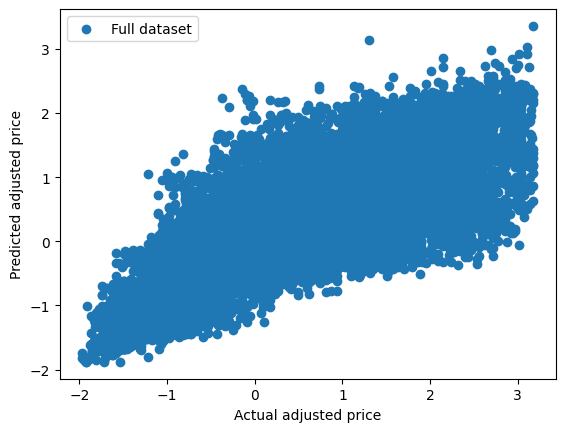

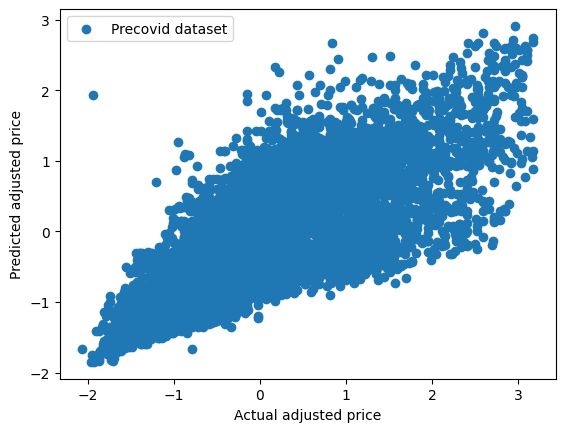

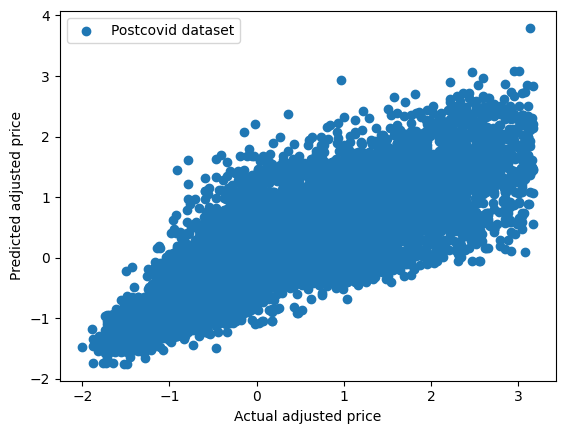

(Full) Correlation coefficient: 0.80239690201378
(Precovid) Correlation coefficient: 0.8049888343336389
(Postcovid) Correlation coefficient: 0.8259881346643154
--------------------------------------------------
(Full) R2 score: 0.6430637799714232
(Precovid) R2 score: 0.64724037502495
(Postcovid) R2 score: 0.6813697829813352
--------------------------------------------------
(Full) Mean squared error: 0.3583199347068274
(Precovid) Mean squared error: 0.3174636105965563
(Postcovid) Mean squared error: 0.3175568701838387
--------------------------------------------------
(Full) Root mean squared error: 0.5985983083060187
(Precovid) Root mean squared error: 0.5634390921799413
(Postcovid) Root mean squared error: 0.5635218453474885


In [16]:
# Predict the adjusted price
y_pred_fulldata = grid_result_fulldata.predict(X_test1)
y_pred_precovid = grid_result_precovid.predict(X_test2)
y_pred_postcovid = grid_result_postcovid.predict(X_test3)

# Plot the predicted adjusted price against the actual adjusted price
plt.scatter(y_test1, y_pred_fulldata, label='Full dataset')
plt.xlabel('Actual adjusted price')
plt.ylabel('Predicted adjusted price')
plt.legend()
plt.show()

plt.scatter(y_test2, y_pred_precovid, label='Precovid dataset')
plt.xlabel('Actual adjusted price')
plt.ylabel('Predicted adjusted price')
plt.legend()
plt.show()

plt.scatter(y_test3, y_pred_postcovid, label='Postcovid dataset')
plt.xlabel('Actual adjusted price')
plt.ylabel('Predicted adjusted price')
plt.legend()
plt.show()

# Calculate the correlation coefficient
correlation_fulldata = np.corrcoef(y_test1, y_pred_fulldata.flatten())[0, 1]
correlation_precovid = np.corrcoef(y_test2, y_pred_precovid.flatten())[0, 1]
correlation_postcovid = np.corrcoef(y_test3, y_pred_postcovid.flatten())[0, 1]
print('(Full) Correlation coefficient:', correlation_fulldata)
print('(Precovid) Correlation coefficient:', correlation_precovid)
print('(Postcovid) Correlation coefficient:', correlation_postcovid)

# Calculate r2 score
from sklearn.metrics import r2_score
r2_fulldata = r2_score(y_test1, y_pred_fulldata)
r2_precovid = r2_score(y_test2, y_pred_precovid)
r2_postcovid = r2_score(y_test3, y_pred_postcovid)
print('-'*50)
print('(Full) R2 score:', r2_fulldata)
print('(Precovid) R2 score:', r2_precovid)
print('(Postcovid) R2 score:', r2_postcovid)

# Obtain the mean squared error
from sklearn.metrics import mean_squared_error
mse_fulldata = mean_squared_error(y_test1, y_pred_fulldata)
mse_precovid = mean_squared_error(y_test2, y_pred_precovid)
mse_postcovid = mean_squared_error(y_test3, y_pred_postcovid)
print('-'*50)
print('(Full) Mean squared error:', mse_fulldata)
print('(Precovid) Mean squared error:', mse_precovid)
print('(Postcovid) Mean squared error:', mse_postcovid)

# Obtain the root mean squared error
from math import sqrt
rmse_fulldata = sqrt(mse_fulldata)
rmse_precovid = sqrt(mse_precovid)
rmse_postcovid = sqrt(mse_postcovid)
print('-'*50)
print('(Full) Root mean squared error:', rmse_fulldata)
print('(Precovid) Root mean squared error:', rmse_precovid)
print('(Postcovid) Root mean squared error:', rmse_postcovid)